In [1]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, QuantumRegister, AncillaRegister
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
import matplotlib as mpl
import matplotlib.pyplot as plt

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram, plot_state_city

import math
import pickle as pkl

In [2]:
#parameters

M = 64 # lattices

w1 = 0.5 
w2 = 0.5 
e1 = 1   ##right
e2 = -1  ##left
cs = 1   ##speed of sound
u = 0.2  ##advection 


x = w1*(1+e1*u/cs**2)
y = w2*(1+e2*u/cs**2)

lambda1 = np.arccos(x)
lambda2 = np.arccos(y)

x,y

(0.6, 0.4)

In [3]:
def oneStep(lambda1,lambda2):
    
    #initializing
    n = int(np.log2(2*M))
    q = QuantumRegister(n,'q')
    a = AncillaRegister(1,'a')

    qc = QuantumCircuit(q)
    qc.add_register(a)
    
    
    qc.barrier()

    #collisions
    def createC(lambda1, lambda2, isC1 = True):
    
        if not isC1:
            lambda1 *= -1
            lambda2 *= -1


        qc=QuantumCircuit(2)

        #phase1 -> x -> phase1 -> x -----ctrl=0
        qc.cp(lambda1, 0 ,1 , ctrl_state = 0)
        qc.cx(0, 1, ctrl_state = 0)
        qc.cp(lambda1, 0, 1, ctrl_state = 0)
        qc.cx(0, 1, ctrl_state = 0)

        #phase2 -> x -> phase2 -> x -----ctrl=1 is default
        qc.cp(lambda2, 0, 1, ctrl_state = 1)
        qc.cx(0, 1)
        qc.cp(lambda2, 0, 1, ctrl_state = 1)
        qc.cx(0, 1)

        return qc
    
    C1 = createC(lambda1, lambda2, True)
    c1gate = C1.to_gate(label = 'c1')
    C2 = createC(lambda1, lambda2, False)
    c2gate = C2.to_gate(label = 'c2')
    
    
    #####adding steps to circuit
    qc.h(a)
    qc.append(c1gate.control(1, ctrl_state = 0),[a,n-1,0])
    qc.append(c2gate.control(1, ctrl_state = 1),[a,n-1,0])
    qc.h(a)
    qc.draw()
    
    
    
    #propagation
    def rshift(n):
        circ = QuantumCircuit(n-1)
        for i in range(n-1):
            if i == n-2:
                circ.x(i)
            else:
                circ.mcx(list(range(i+1,n-1)), i)
        return circ

    def lshift(n):
        circ = QuantumCircuit(n-1)
        for i in reversed(range(n-1)):
            if i == n-2:
                circ.x(i)
            else:
                circ.mcx(list(range(i+1,n-1)), i)
        return circ
    
    qc.barrier()
    R = rshift(n).to_gate(label = "R").control(1, ctrl_state = 0)#.control(1, ctrl_state = 0)
    L = lshift(n).to_gate(label = "L").control(1, ctrl_state = 1)#.control(1, ctrl_state = 0)
    
    cbits = [n-1]
    cbits.extend([i for i in range(n-2,-1,-1)])  

    qc.append(R,cbits)
    qc.append(L,cbits)

    
    ######################### macros
    qc.swap(a,n-1)
    qc.h(a)
#     qc.h(n-1)

    return qc

In [4]:
qc = oneStep(np.arccos(x),np.arccos(y))
qc.draw() # saves the circuit in a file called qd1q2

░      ┌─────┐┌─────┐      ░ ┌────┐┌────┐        
q_0: ─░──────┤1    ├┤1    ├──────░─┤5   ├┤5   ├────────
      ░      │     ││     │      ░ │    ││    │        
q_1: ─░──────┤     ├┤     ├──────░─┤4   ├┤4   ├────────
      ░      │     ││     │      ░ │    ││    │        
q_2: ─░──────┤     ├┤     ├──────░─┤3   ├┤3   ├────────
      ░      │     ││     │      ░ │  R ││  L │        
q_3: ─░──────┤  c1 ├┤  c2 ├──────░─┤2   ├┤2   ├────────
      ░      │     ││     │      ░ │    ││    │        
q_4: ─░──────┤     ├┤     ├──────░─┤1   ├┤1   ├────────
      ░      │     ││     │      ░ │    ││    │        
q_5: ─░──────┤     ├┤     ├──────░─┤0   ├┤0   ├────────
      ░      │     ││     │      ░ └─┬──┘└─┬──┘        
q_6: ─░──────┤0    ├┤0    ├──────░───o─────■────X──────
      ░ ┌───┐└──┬──┘└──┬──┘┌───┐ ░              │ ┌───┐
  a: ─░─┤ H ├───o──────■───┤ H ├─░──────────────X─┤ H ├
      ░ └───┘              └───┘ ░                └───┘

In [5]:
#### initialState
initState = np.ones(M)/10  #0.1 everywhere
initState[12] = 0.2
nrm = np.linalg.norm(initState)
initState = np.concatenate((initState,initState))
#### statevector

SV = Statevector(initState/np.linalg.norm(initState)).expand([1,0])
initSV = SV #save for future reference

In [6]:
def timestep(sv):
    return sv.evolve(qc)

def graph(sv, color = "red"):
    plt.plot(list(range(0,M,1)), np.array(sv)[:M:1],color)
    plt.plot(list(range(M,2*M,1)), np.array(sv)[M:2*M:1],color)
    plt.plot(list(range(2*M,3*M,1)), np.array(sv)[2*M:3*M:1],color)
    plt.plot(list(range(3*M,4*M,1)), np.array(sv)[3*M::1],color)
    
def hres(sv):
    plt.plot(list(range(0,M,1)), 2**(1)*nrm*np.array(sv)[:M:])
    plt.xlabel("Lattice site")
    plt.ylabel("Concentration")
def hres2(sv):
    plt.plot(list(range(0,M,1)), 2**(1)*nrm2*np.array(sv)[:M:])  
def reinit(sv):
    tmp = np.array(sv)[:M]
    tmp = np.concatenate((tmp,tmp))
    return Statevector(tmp/np.linalg.norm(tmp)).expand([1,0])

In [7]:
# sorts counts
def sort_counts(counts):
    keys = list(counts.keys())
    keys.sort()
    counts = {i: counts[i] for i in keys}
    return counts

In [8]:
# sorts and converts values of counts
def process_counts(counts):
    keys = list(counts.keys())
    keys.sort()
    counts = {i: 2**(1)*nrm*math.sqrt(counts[i]) for i in keys}
    return counts

In [9]:
def simulate_statevector(sv, qc, nshots=1_000_000):
    simulator = AerSimulator()
    # simulator = AerSimulator.from_backend(FakeBrisbane())
    # prepare the state of the given state vector
    circ = QuantumCircuit(qc.num_qubits)
    circ.prepare_state(sv)
    circ.measure_all()

    circ = transpile(circ, simulator)
    result = simulator.run(circ, shots=nshots).result()
    counts = result.get_counts(circ)

    return sort_counts(counts)

In [10]:
def save_fig(counts, i, type="quantum"):
    vals = np.array(list(counts.values())) 

    plt.xlabel("Lattice Site")
    plt.ylabel("Number Shots")
    plt.title(f"Number Shots at Lattice Sites at t = {i}")

    plt.plot(list(range(0,M,1)), vals[:M:])

    plt.savefig(f'd1q2_{type}_simulation/{i}.png')

    plt.close('all')

In [11]:
# RESET
#### initialState
def reset_sv():
    initState = np.ones(M)/10  #0.1 everywhere
    initState[12] = 0.2
    nrm = np.linalg.norm(initState)
    initState = np.concatenate((initState,initState))
    #### statevector

    SV = Statevector(initState/np.linalg.norm(initState)).expand([1,0])
    initSV = SV #save for future reference

    return SV

In [12]:
print(nrm)

0.8185352771872451


In [24]:
# sorts and converts values of counts
def process_counts(counts):
    keys = list(counts.keys())
    keys.sort()

    counts = {i: counts[i] for i in keys}
    # counts = {i: 2**(1)*nrm*math.sqrt(counts[i]) for i in keys}
    
    vals = list(counts.values())
    sum = 0
    for i in vals:
        sum = sum + i

    for i in range(len(vals)):
        vals[i] = vals[i] / sum

    counts = {keys[i]: 2**(1)*nrm*math.sqrt(vals[i]) for i in range(len(keys))}
    return counts

/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/melod/anaconda3/envs/qiskit1/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


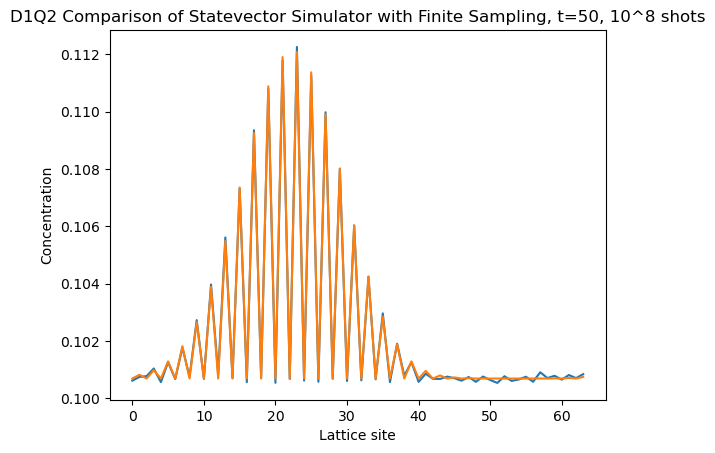

In [28]:
# hres(initSV)
# SAVE FIGURES FOR STATEVECTOR SIMULATION
iterations = 50
min_pow = 8
max_pow = 8

SV = reset_sv()

qc = oneStep(np.arccos(x),np.arccos(y))

counts_all = {}
sv_all = {}

for j in range(min_pow, max_pow + 1):
    for i in range(iterations + 1):
        SV = timestep(SV)

        if i == 50:
            

            counts = simulate_statevector(SV, qc, nshots=pow(10, j))
            processed_counts = process_counts(counts)

            vals = np.array(list(processed_counts.values())) 
            plt.plot(list(range(0,M,1)), vals[:M:], label='Finite Sampling')
            plt.plot(list(range(0,M,1)), 2**(1)*nrm*np.array(SV)[:M:], label='Statevector Simulation')
            
            plt.xlabel("Lattice site")
            plt.ylabel("Concentration")
            plt.title(f'D1Q2 Comparison of Statevector Simulator with Finite Sampling, t={i}, 10^{j} shots')

        SV = reinit(SV)

    

In [15]:
with open('data/d1q2_sampleincr_counts.pkl', 'wb') as f:
    pkl.dump(counts_all, f)

with open('data/d1q2_sampleincr_statevector.pkl', 'wb') as f:
    pkl.dump(sv_all, f)